<a href="https://colab.research.google.com/github/gyiernahfufie/COVID-Analysis---US-and-India/blob/main/COVID_Analysis_US_and_India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fbprophet

# Importing necessary library

In [ ]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import copy
import seaborn as sns
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools

In [ ]:
%cd /content/drive/MyDrive/Aon

/content/drive/MyDrive/Aon


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Aon/covid_19_data.csv')

# Raw Data Exploration

In [ ]:
data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
data.describe()

,SNo,Confirmed,Deaths,Recovered
count,306429.000000,3.064290e+05,306429.000000,3.064290e+05
mean,153215.000000,8.567091e+04,2036.403268,5.042029e+04
std,88458.577156,2.775516e+05,6410.938048,2.015124e+05
min,1.000000,-3.028440e+05,-178.000000,-8.544050e+05
25%,76608.000000,1.042000e+03,13.000000,1.100000e+01
50%,153215.000000,1.037500e+04,192.000000,1.751000e+03
75%,229822.000000,5.075200e+04,1322.000000,2.027000e+04
max,306429.000000,5.863138e+06,112385.000000,6.399531e+06


# Data Pre-processing

**Checking Missing Values**

In [ ]:
data.isnull().sum()

SNo                    0
ObservationDate        0
Province/State     78100
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64

In [ ]:
data['Province/State'].fillna('Unknown', inplace = True)
#replacing missing values in Province/State column with 'Unknown'

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SNo              306429 non-null  int64  
 1   ObservationDate  306429 non-null  object 
 2   Province/State   306429 non-null  object 
 3   Country/Region   306429 non-null  object 
 4   Last Update      306429 non-null  object 
 5   Confirmed        306429 non-null  float64
 6   Deaths           306429 non-null  float64
 7   Recovered        306429 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 18.7+ MB


In [ ]:
data['ObservationDate'] = pd.to_datetime(data['ObservationDate'], format = '%m/%d/%Y')
#Changing 'ObservationDate' to datetime format

In [ ]:
newdata = copy.deepcopy(data)
#making a copy of the dataset

**Feature Engineering**

In [ ]:
#creating new variable, 'Active Cases'.
newdata['Active Cases'] = newdata['Confirmed'] - newdata['Deaths'] - newdata['Recovered']

In [ ]:
#removing unused columns
newdata = newdata.drop(['SNo', 'Last Update'], axis = 1)

In [ ]:
newdata.to_csv(r'/content/drive/MyDrive/Aon/newdata.csv', index = True)

Splitting global dataset to US and India focused dataset

In [ ]:
indiadata = newdata.loc[(newdata['Country/Region'] == 'India')]

In [ ]:
usdata = newdata.loc[(newdata['Country/Region'] == 'US')]

Aggregating cases based on Country and Date

In [ ]:
indiadata_country = indiadata.groupby(['ObservationDate','Country/Region']).sum()
indiadata_country = indiadata_country.reset_index()

In [ ]:
usdata_country = usdata.groupby(['ObservationDate','Country/Region']).sum()
usdata_country = usdata_country.reset_index()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = indiadata_country['ObservationDate'], y = indiadata_country['Confirmed'], name = 'Confirmed',
                         line = dict(color = 'blue', width = 4)))
fig.add_trace(go.Scatter( x = indiadata_country['ObservationDate'], y = indiadata_country['Recovered'], name = 'Recovered',
                         line = dict(color = 'green', width = 4)))
fig.add_trace(go.Scatter( x = indiadata_country['ObservationDate'], y = indiadata_country['Deaths'], name = 'Deaths',
                         line = dict(color = 'firebrick', width = 4)))

fig.update_layout(
    title = 'COVID-19 in India over time',
    yaxis = dict(
        title = 'Number of Cases Per Day'
    )
)

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = usdata_country['ObservationDate'], y = usdata_country['Confirmed'], name = 'Confirmed',
                         line = dict(color = 'blue', width = 4)))
fig.add_trace(go.Scatter( x = usdata_country['ObservationDate'], y = usdata_country['Recovered'], name = 'Recovered',
                         line = dict(color = 'green', width = 4)))
fig.add_trace(go.Scatter( x = usdata_country['ObservationDate'], y = usdata_country['Deaths'], name = 'Deaths',
                         line = dict(color = 'firebrick', width = 4)))

fig.update_layout(
    title = 'COVID-19 in US over time',
    yaxis = dict(
        title = 'Number of Cases Per Day'
    )
)

fig.show()

In [ ]:
indiadata_country = indiadata_country.set_index('ObservationDate')
usdata_country = usdata_country.set_index('ObservationDate')

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result1 = seasonal_decompose(indiadata_country['Confirmed'], model='multiplicative')
result2 = seasonal_decompose(indiadata_country['Recovered'], model='add')
result3 = seasonal_decompose(indiadata_country['Deaths'], model='add')

fig = go.Figure()
fig.add_trace(go.Scatter(x=indiadata_country.index, y=result1.trend, name='Confirmed',
                         line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=indiadata_country.index, y=result2.trend, name='Recovered',
                         line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=indiadata_country.index, y=result3.trend, name='Deaths',
                         line=dict(color='firebrick', width=4)))

fig.update_layout(
    title='Trend Component in Data',
     yaxis=dict(
        title='Number of Cases Per Day')
    )

fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
result1 = seasonal_decompose(usdata_country['Confirmed'], model='multiplicative')
result2 = seasonal_decompose(usdata_country['Recovered'], model='add')
result3 = seasonal_decompose(usdata_country['Deaths'], model='add')

fig = go.Figure()
fig.add_trace(go.Scatter(x=usdata_country.index, y=result1.trend, name='Confirmed',
                         line=dict(color='blue', width=4)))
fig.add_trace(go.Scatter(x=usdata_country.index, y=result2.trend, name='Recovered',
                         line=dict(color='green', width=4)))
fig.add_trace(go.Scatter(x=usdata_country.index, y=result3.trend, name='Deaths',
                         line=dict(color='firebrick', width=4)))

fig.update_layout(
    title='Trend Component in Data',
     yaxis=dict(
        title='Number of Cases Per Day')
    )

fig.show()

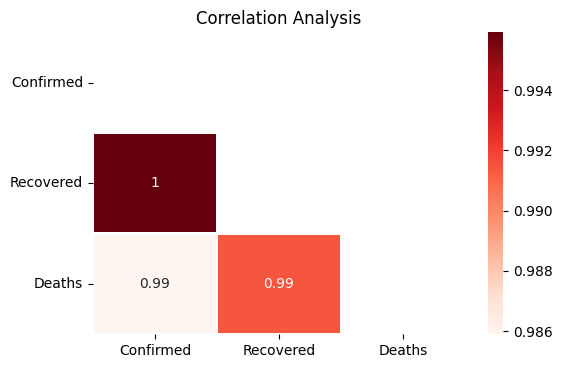

In [ ]:
corr = indiadata_country[['Confirmed','Recovered','Deaths']].corr()
mask = np.triu(np.ones_like(corr,dtype = bool))

plt.figure(dpi=100)
plt.title('Correlation Analysis')
sns.heatmap(corr,mask=mask,annot=True,lw=1,linecolor='white',cmap='Reds')
plt.xticks(rotation=0)
plt.yticks(rotation = 0)
plt.show()

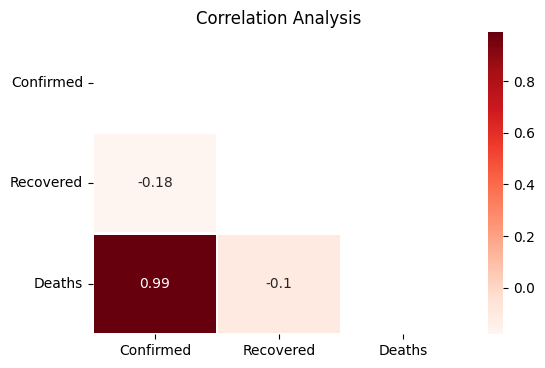

In [ ]:
corr = usdata_country[['Confirmed','Recovered','Deaths']].corr()
mask = np.triu(np.ones_like(corr,dtype = bool))

plt.figure(dpi=100)
plt.title('Correlation Analysis')
sns.heatmap(corr,mask=mask,annot=True,lw=1,linecolor='white',cmap='Reds')
plt.xticks(rotation=0)
plt.yticks(rotation = 0)
plt.show()

Data quality issues exist in recovered column.

In [ ]:
indiadata_country2 = copy.deepcopy(indiadata_country)

In [ ]:
#creating new variable, 'Daily New Cases' based on cumulative confirmed cases.
indiadata_country2['Daily New Cases'] = indiadata_country2.sort_values('ObservationDate')['Confirmed'].transform(lambda x: x.diff())
#creating new variable, 'Daily New Death Cases' based on cumulative death cases.
indiadata_country2['Daily New Death Cases'] = indiadata_country2.sort_values('ObservationDate')['Deaths'].transform(lambda x: x.diff())
#creating new variable, 'Daily Recovered Cases' based on cumulative recovered cases.
indiadata_country2['Daily New Recovered Cases'] = indiadata_country2.sort_values('ObservationDate')['Recovered'].transform(lambda x: x.diff())

In [ ]:
indiadata_country2.fillna(0, inplace = True)

In [ ]:
indiadata_country2['New Cases Growth Rate'] = indiadata_country2.sort_values('ObservationDate')['Daily New Cases'].transform(lambda x:x/x.shift(1))
indiadata_country2['Infection Fatality Rate'] = indiadata_country2['Deaths'] / indiadata_country2['Confirmed']

In [ ]:
usdata_country2 = copy.deepcopy(usdata_country)

In [ ]:
#creating new variable, 'Daily New Cases' based on cumulative confirmed cases.
usdata_country2['Daily New Cases'] = usdata_country2.sort_values('ObservationDate')['Confirmed'].transform(lambda x: x.diff())
#creating new variable, 'Daily New Death Cases' based on cumulative death cases.
usdata_country2['Daily New Death Cases'] = usdata_country2.sort_values('ObservationDate')['Deaths'].transform(lambda x: x.diff())
#creating new variable, 'Daily Recovered Cases' based on cumulative recovered cases.
usdata_country2['Daily New Recovered Cases'] = usdata_country2.sort_values('ObservationDate')['Recovered'].transform(lambda x: x.diff())

In [ ]:
usdata_country2.fillna(0, inplace = True)

In [ ]:
usdata_country2['New Cases Growth Rate'] = usdata_country2.sort_values('ObservationDate')['Daily New Cases'].transform(lambda x:x/x.shift(1))
usdata_country2['Infection Fatality Rate'] = usdata_country2['Deaths'] / usdata_country2['Confirmed']

In [ ]:
indiadata_country2.to_csv(r'/content/drive/MyDrive/Aon/indiadatacountry.csv', index = True)
usdata_country2.to_csv(r'/content/drive/MyDrive/Aon/usdatacountry.csv', index = True)

In [ ]:
indiadata_country2 = indiadata_country2.reset_index()
india_confirmed = indiadata_country2[['ObservationDate','Confirmed']]
india_recovered = indiadata_country2[['ObservationDate','Recovered']]
india_deaths = indiadata_country2[['ObservationDate','Deaths']]
india_active = indiadata_country2[['ObservationDate','Active Cases']]

In [ ]:
india_daily_new = indiadata_country2[['ObservationDate','Daily New Cases']]

In [ ]:
#function for renaming columns to ds and y based on requirement by Prophet
def rename_func(df):
  cols = df.columns
  df = df.rename(columns = {cols[0]: 'ds', cols[1]: 'y'})
  return df

In [ ]:
india_confirmed = rename_func(india_confirmed)
india_recovered = rename_func(india_recovered)
india_deaths = rename_func(india_deaths)
india_active = rename_func(india_active)

In [ ]:
india_daily_new = rename_func(india_daily_new)

In [ ]:
split_range = len(india_confirmed) - 14

# Splitting training and testing dataset

In [ ]:
train_india = india_confirmed[:split_range]
test_india = india_confirmed[split_range:]

In [ ]:
split_range_india = len(india_daily_new) - 14 #to forecast 14 days ahead
train_india_daily = india_daily_new[:split_range_india]
test_india_daily = india_daily_new[split_range_india:]

In [ ]:
print('India train set:',train_india.shape)
print('India test set:',test_india.shape)

India train set: (472, 2)
India test set: (14, 2)


In [ ]:
usdata_country2 = usdata_country2.reset_index()
us_confirmed = usdata_country2[['ObservationDate','Confirmed']]
us_recovered = usdata_country2[['ObservationDate','Recovered']]
us_deaths = usdata_country2[['ObservationDate','Deaths']]
us_active = usdata_country2[['ObservationDate','Active Cases']]

In [ ]:
us_daily_new = usdata_country2[['ObservationDate','Daily New Cases']]
us_daily_new = rename_func(us_daily_new)

In [ ]:
us_confirmed = rename_func(us_confirmed)
us_recovered = rename_func(us_recovered)
us_deaths = rename_func(us_deaths)
us_active = rename_func(us_active)

In [ ]:
split_range_us = len(us_confirmed) - 14
train_us = us_confirmed[:split_range_us]
test_us = us_confirmed[split_range_us:]

In [ ]:
print('US train set:',train_us.shape)
print('US test set:',test_us.shape)

US train set: (480, 2)
US test set: (14, 2)


In [ ]:
train_us_daily = us_daily_new[:split_range_us]
test_us_daily = us_daily_new[split_range_us:]

# FB Prophet Model

In [ ]:
import json
from fbprophet.serialize import model_to_json, model_from_json

1. model_india2: Cumulative Cases model. 23.58%
2. model_india_daily: Daily Cases model. 76.91%
3. model_us: Cumulative Cases model. 80.43%
4. model_us_daily: Daily Cases model. 38.04%
5. model_india_daily_oos: For 14 days ahead forecast.
6. model_us_oos: For 14 days ahead forecast.

# India - Cumulative Cases - X

In [ ]:
model_india = Prophet(weekly_seasonality = False, yearly_seasonality = False, daily_seasonality = False, 
                      seasonality_mode = 'additive', changepoint_prior_scale = 0.3, changepoint_range = 0.99)
model_india.add_seasonality(name = 'Monthly', period = 30.5, fourier_order = 5)
model_india.add_country_holidays(country_name = 'IN')

In [ ]:
model_india.fit(train_india)

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



In [ ]:
future_dates_india = model_india.make_future_dataframe(periods = 14)

In [ ]:
predictions_india = model_india.predict(future_dates_india)

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



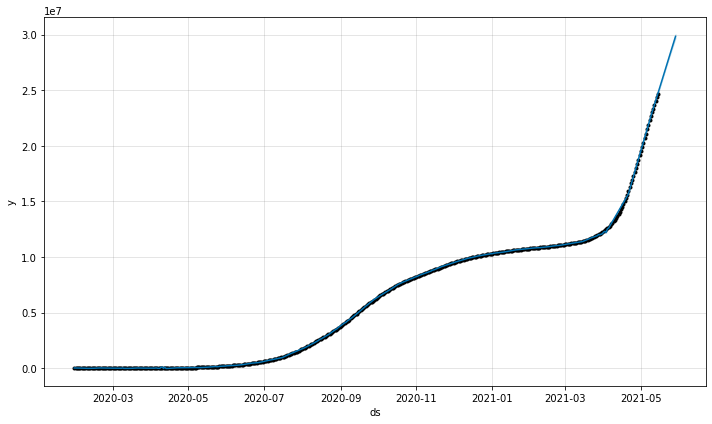

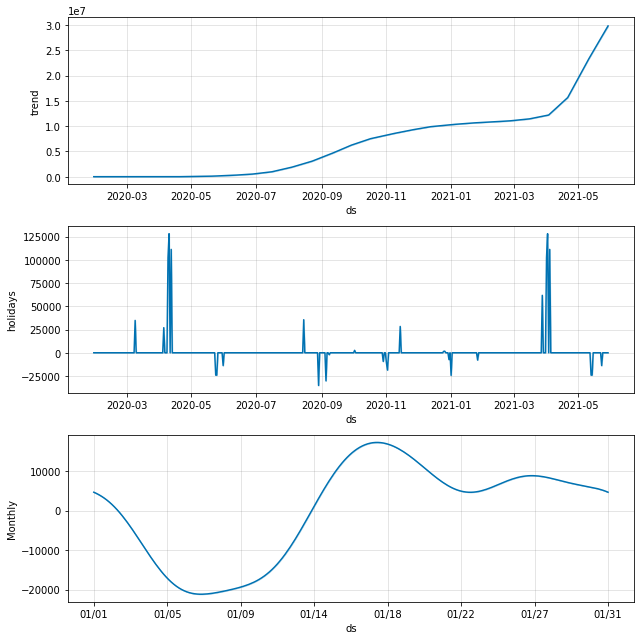

In [ ]:
model_india.plot(predictions_india);
model_india.plot_components(predictions_india);

#dotted lines = actual data, blue line = predictions 

In [ ]:
def check_metrics(test, predictions,split_range):
  R2_score = r2_score(test['y'], predictions['yhat'].iloc[split_range:])
  print(f"R-Squared Score:{R2_score}")

In [ ]:
check_metrics(test_india, predictions_india,split_range_india)

R-Squared Score:-0.43407931016320367


In [ ]:
mean_absolute_error(y_true=test_india['y'],
                   y_pred=predictions_india['yhat'].iloc[split_range_india:])

952965.3882178443

In [ ]:
mean_squared_error(y_true=test_india['y'],
                   y_pred=predictions_india['yhat'].iloc[split_range_india:])

1204397048057.013

# Hyperparameter Tuning for India Cumulative Cases Model

In [ ]:
# param_grid = {
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'holidays_prior_scale':[0.01,0.1,1.0,10.0],
#     'seasonality_mode': ['additive', 'multiplicative']
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

In [ ]:
# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(train_india)  # Fit model with given params
#     df_cv = cross_validation(m, period ='7 days', horizon='14 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

In [ ]:
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [ ]:
# best_params = all_params[np.argmin(rmses)]
# print(best_params)

Re-train with tuned hyperparameters

#India Cumulative Cases - Tuned 23.58%

In [ ]:
model_india2 = Prophet(weekly_seasonality = False, yearly_seasonality = False, daily_seasonality = False, 
                      seasonality_mode = 'additive', changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1, 
                       holidays_prior_scale = 0.01, changepoint_range = 0.99, interval_width = 0.95)
model_india2.add_seasonality(name = 'Monthly', period = 30.5, fourier_order = 5)
model_india2.add_country_holidays(country_name = 'IN')

In [ ]:
model_india2.fit(train_india)

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



In [ ]:
future_dates_india2 = model_india2.make_future_dataframe(periods = 14)
predictions_india2 = model_india2.predict(future_dates_india2)

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



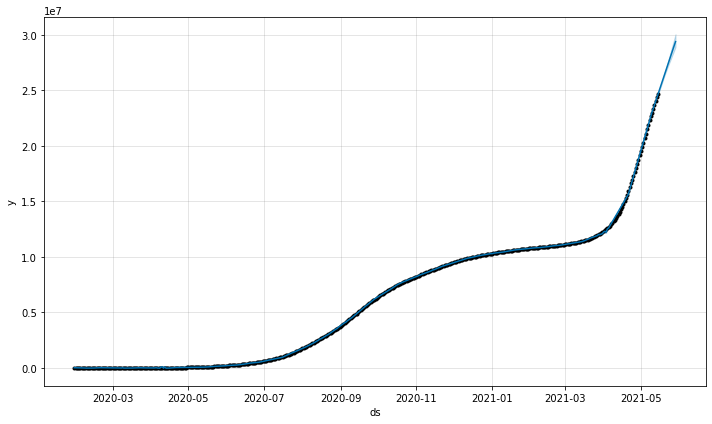

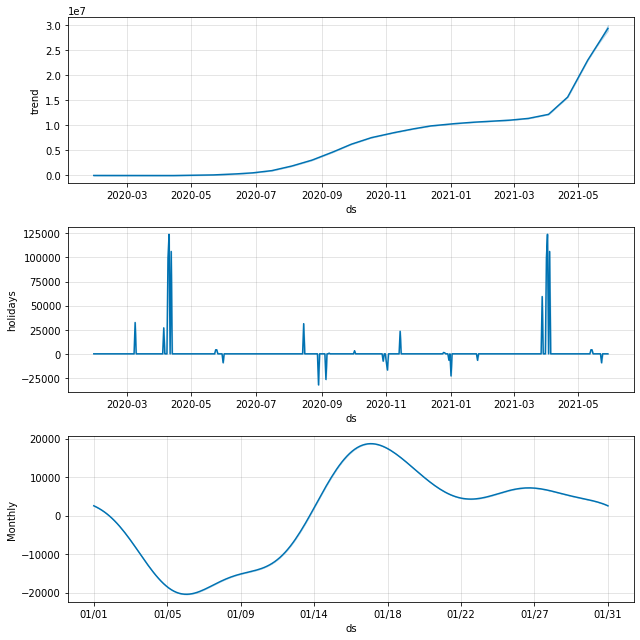

In [ ]:
model_india2.plot(predictions_india2);
model_india2.plot_components(predictions_india2);

In [ ]:
check_metrics(test_india, predictions_india2,split_range_india)

R-Squared Score:0.23588183955934416


In [ ]:
mean_absolute_error(y_true=test_india['y'],
                   y_pred=predictions_india2['yhat'].iloc[split_range_india:])

668949.3814658347

In [ ]:
mean_squared_error(y_true=test_india['y'],
                   y_pred=predictions_india2['yhat'].iloc[split_range_india:])

641736932036.7275

In [ ]:
forecast_india_tuned = predictions_india2[['ds','yhat_lower','yhat_upper','yhat']].tail(14).reset_index().set_index('ds').drop('index', axis = 1)
forecast_india_tuned

,yhat_lower,yhat_upper,yhat
ds,,,
2021-05-16,2.495296e+07,2.511142e+07,2.503347e+07
2021-05-17,2.528581e+07,2.544943e+07,2.536965e+07
2021-05-18,2.561360e+07,2.579548e+07,2.570836e+07
2021-05-19,2.595481e+07,2.615044e+07,2.604927e+07
2021-05-20,2.628074e+07,2.652766e+07,2.639062e+07
2021-05-21,2.659244e+07,2.689496e+07,2.673027e+07
2021-05-22,2.688684e+07,2.728173e+07,2.706686e+07
2021-05-23,2.719285e+07,2.765822e+07,2.739100e+07
2021-05-24,2.747737e+07,2.805070e+07,2.773137e+07


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = test_india['ds'], y = test_india['y'], name = 'Actual',))
fig.add_trace(go.Scatter(x = forecast_india_tuned.reset_index()['ds'] , y = forecast_india_tuned['yhat_lower'],
                         line = dict(color = 'firebrick', width = 1, dash = 'dash'),name = '95% Lower Uncertainty Interval',))
fig.add_trace(go.Scatter(x = forecast_india_tuned.reset_index()['ds'] , y = forecast_india_tuned['yhat_upper'],
                         line = dict(color = 'firebrick', width = 1, dash = 'dash'),name = '95% Upper Uncertainty Interval',))
fig.add_trace(go.Scatter( x = forecast_india_tuned.reset_index()['ds'], y = forecast_india_tuned['yhat'], name = 'Predicted',line = dict(color = 'firebrick')))
fig.update_layout(title = 'Actual vs Predicted Cases in India', xaxis_title = 'Date', yaxis_title = 'Number of COVID-19 Cases')
fig.show()

In [ ]:
with open('model_india2.json', 'w') as fout:
    json.dump(model_to_json(model_india2), fout)  # Save model

# with open('model_india2.json', 'r') as fin:
#     m = model_from_json(json.load(fin))  # Load model

# Hyperparameter Tuning India Daily Cases

In [ ]:
# param_grid = {
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'holidays_prior_scale':[0.01,0.1,1.0,10.0],
#     'seasonality_mode': ['additive', 'multiplicative']
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

In [ ]:
# # # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(train_india_daily)  # Fit model with given params
#     df_cv = cross_validation(m, period ='7 days', horizon='14 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

In [ ]:
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

# best_params = all_params[np.argmin(rmses)]
# print(best_params)

# India Daily Cases - Tuned 76.91%

In [ ]:
model_india_daily = Prophet(weekly_seasonality = True, yearly_seasonality = False, daily_seasonality = False, 
                      seasonality_mode = 'additive', changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1, 
                       holidays_prior_scale = 0.01, changepoint_range = 0.99)
model_india_daily.add_country_holidays(country_name = 'IN')

In [ ]:
model_india_daily.fit(train_india_daily)
future_dates_india_daily = model_india_daily.make_future_dataframe(periods = 14)
predictions_india_daily = model_india_daily.predict(future_dates_india_daily)

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



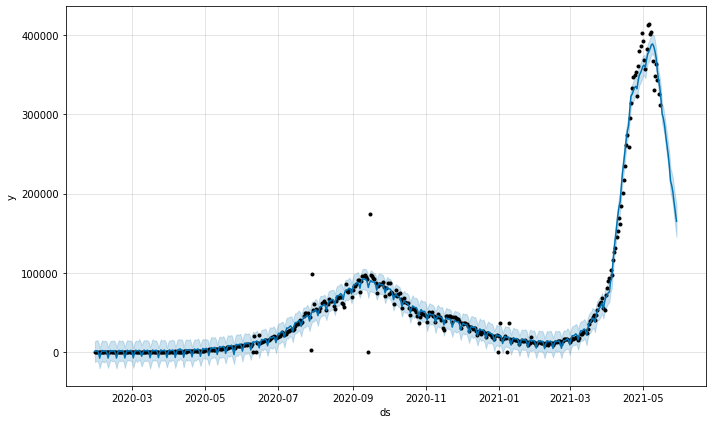

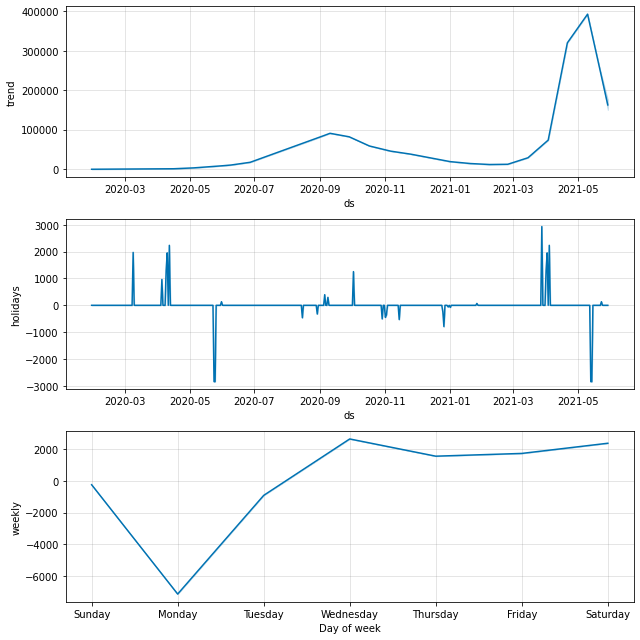

In [ ]:
model_india_daily.plot(predictions_india_daily);
model_india_daily.plot_components(predictions_india_daily);

In [ ]:
check_metrics(test_india_daily, predictions_india_daily,split_range_india)

R-Squared Score:0.7691579208307142


In [ ]:
mean_absolute_error(y_true=test_india_daily['y'],
                   y_pred=predictions_india_daily['yhat'].iloc[split_range_india:])

13463.802208526811

In [ ]:
mean_squared_error(y_true=test_india_daily['y'],
                   y_pred=predictions_india_daily['yhat'].iloc[split_range_india:])

333273575.158019

In [ ]:
# (weekly_seasonality = True, yearly_seasonality = False, daily_seasonality = False, 
#                       seasonality_mode = 'multiplicative', changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1, 
#                        holidays_prior_scale = 0.01, changepoint_range = 0.99)
#--r2 = -0.90

In [ ]:
forecast_india_tuned_daily = predictions_india_daily[['ds','yhat_lower','yhat_upper','yhat']].tail(14).reset_index().set_index('ds').drop('index', axis = 1)
forecast_india_tuned_daily

,yhat_lower,yhat_upper,yhat
ds,,,
2021-05-16,306596.566635,333607.579595,319801.145245
2021-05-17,288023.749384,313229.329284,300811.890867
2021-05-18,282008.795532,307910.734560,294905.238758
2021-05-19,273828.414133,298893.481431,286343.154330
2021-05-20,259611.590442,286600.346445,273147.032554
2021-05-21,248306.094356,275983.952455,261207.728637
2021-05-22,236554.319027,263611.104992,249735.249424
2021-05-23,221983.472798,250697.419164,235146.129061
2021-05-24,201425.951897,231512.348998,216023.478358


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = test_india_daily['ds'], y = test_india_daily['y'], name = 'Actual',))
fig.add_trace(go.Scatter(x = forecast_india_tuned_daily.reset_index()['ds'] , y = forecast_india_tuned_daily['yhat_lower'],
                         line = dict(color = 'firebrick', width = 1, dash = 'dash'),name = 'Lower Uncertainty Interval',))
fig.add_trace(go.Scatter(x = forecast_india_tuned_daily.reset_index()['ds'] , y = forecast_india_tuned_daily['yhat_upper'],
                         line = dict(color = 'firebrick', width = 1, dash = 'dash'),name = 'Upper Uncertainty Interval',))
fig.add_trace(go.Scatter( x = forecast_india_tuned_daily.reset_index()['ds'], y = forecast_india_tuned_daily['yhat'], 
                             line = dict(color = 'firebrick'),name = 'Predicted',))
fig.update_layout(title = 'Actual vs Predicted Daily Cases in India', xaxis_title = 'Date', yaxis_title = 'Number of COVID-19 Cases')
fig.show()

In [ ]:
with open('model_india_daily.json', 'w') as fout:
    json.dump(model_to_json(model_india_daily), fout)  # Save model

# with open('model_india_daily.json', 'r') as fin:
#     m = model_from_json(json.load(fin))  # Load model

# US Cumulative Cases 80.43%

In [ ]:
model_us = Prophet(weekly_seasonality = False, yearly_seasonality = False, daily_seasonality = False, 
                      seasonality_mode = 'additive', changepoint_prior_scale = 0.3, changepoint_range = 0.99)
model_us.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_us.add_country_holidays(country_name = 'US')

In [ ]:
model_us.fit(train_us)

In [ ]:
future_dates_us = model_us.make_future_dataframe(periods = 14)

In [ ]:
predictions_us = model_us.predict(future_dates_us)

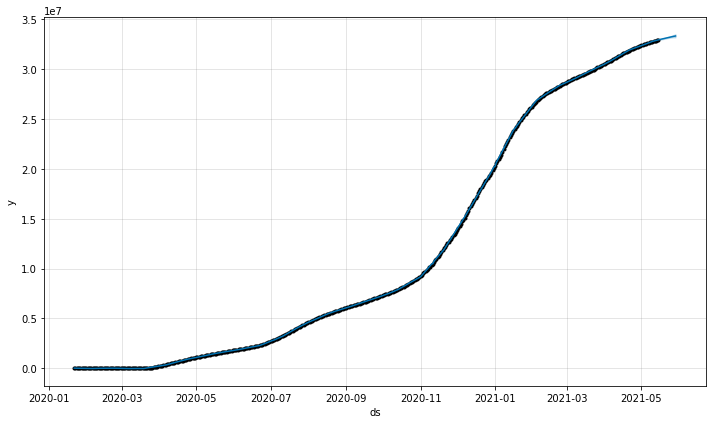

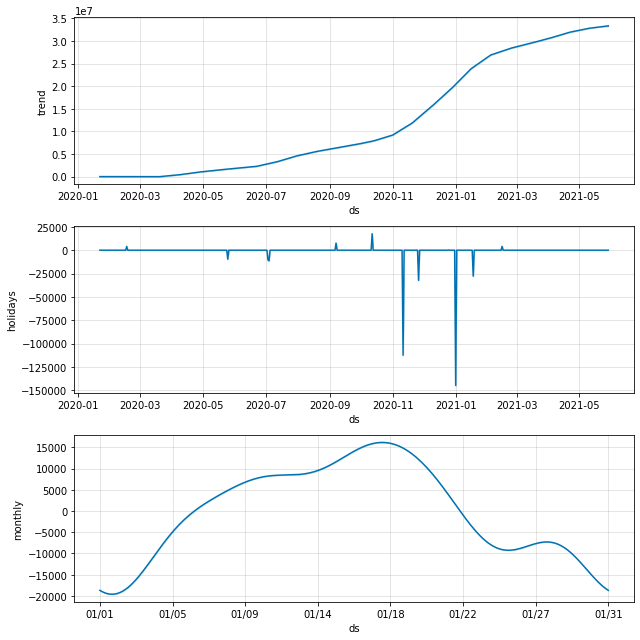

In [ ]:
model_us.plot(predictions_us)
model_us.plot_components(predictions_us);

In [ ]:
check_metrics(test_us, predictions_us,split_range_us)

R-Squared Score:0.8043552428347405


In [ ]:
mean_squared_error(y_true=test_us['y'],
                   y_pred=predictions_us['yhat'].iloc[split_range_us:])

1830110213.8897636

In [ ]:
mean_absolute_error(y_true=test_us['y'],
                   y_pred=predictions_us['yhat'].iloc[split_range_us:])

39885.96735318537

In [ ]:
forecast_us = predictions_us[['ds','yhat_lower','yhat_upper','yhat']].tail(14).reset_index().set_index('ds').drop('index', axis = 1)
forecast_us

,yhat_lower,yhat_upper,yhat
ds,,,
2021-05-16,3.291834e+07,3.301501e+07,3.296368e+07
2021-05-17,3.294285e+07,3.303816e+07,3.299218e+07
2021-05-18,3.297275e+07,3.307267e+07,3.302057e+07
2021-05-19,3.299704e+07,3.310485e+07,3.304961e+07
2021-05-20,3.302775e+07,3.313734e+07,3.307962e+07
2021-05-21,3.304999e+07,3.317366e+07,3.311016e+07
2021-05-22,3.307807e+07,3.320861e+07,3.314031e+07
2021-05-23,3.310067e+07,3.324694e+07,3.316923e+07
2021-05-24,3.312489e+07,3.327707e+07,3.319651e+07


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = test_us['ds'], y = test_us['y'], name = 'Actual',))
fig.add_trace(go.Scatter(x = forecast_us.reset_index()['ds'] , y = forecast_us['yhat_lower'],
                         line = dict(color = 'firebrick', width = 1, dash = 'dash'),name = 'Lower Uncertainty Interval',))
fig.add_trace(go.Scatter(x = forecast_us.reset_index()['ds'] , y = forecast_us['yhat_upper'],
                         line = dict(color = 'firebrick', width = 1, dash = 'dash'),name = 'Upper Uncertainty Interval',))
fig.add_trace(go.Scatter( x = forecast_us.reset_index()['ds'], y = forecast_us['yhat'], 
                             line = dict(color = 'firebrick'),name = 'Predicted',))
fig.update_layout(title = 'Actual vs Predicted Cases in US', xaxis_title = 'Date', yaxis_title = 'Number of COVID-19 Cases')
fig.show()

In [ ]:
with open('model_us.json', 'w') as fout:
    json.dump(model_to_json(model_us), fout)  # Save model

# with open('model_us.json', 'r') as fin:
#     m = model_from_json(json.load(fin))  # Load model

# Hyperparameter Tuning US Cumulative Cases

In [ ]:
# param_grid = {
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'holidays_prior_scale':[0.01,0.1,1.0,10.0],
#     'seasonality_mode': ['additive', 'multiplicative']
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

In [ ]:
# # # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(train_us)  # Fit model with given params
#     df_cv = cross_validation(m, period ='7 days', horizon='14 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

In [ ]:
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

# best_params = all_params[np.argmin(rmses)]
# print(best_params)

# US Cumulative Cases - Tuned - X

In [ ]:
model_us2 = Prophet(weekly_seasonality = False, yearly_seasonality = False, daily_seasonality = False, 
                      seasonality_mode = 'additive', changepoint_prior_scale = 0.5, seasonality_prior_scale = 10,
                     changepoint_range = 0.99, holidays_prior_scale = 0.01, interval_width = 0.95)
model_us2.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_us2.add_country_holidays(country_name = 'US')

In [ ]:
model_us2.fit(train_us)
future_dates_us2 = model_us2.make_future_dataframe(periods = 14)
predictions_us2 = model_us2.predict(future_dates_us2)

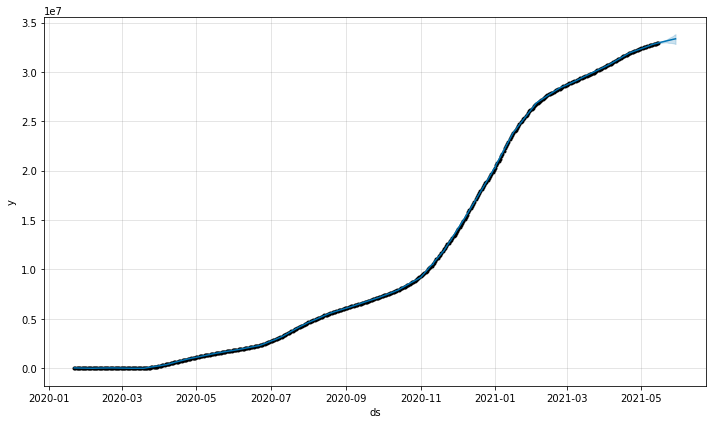

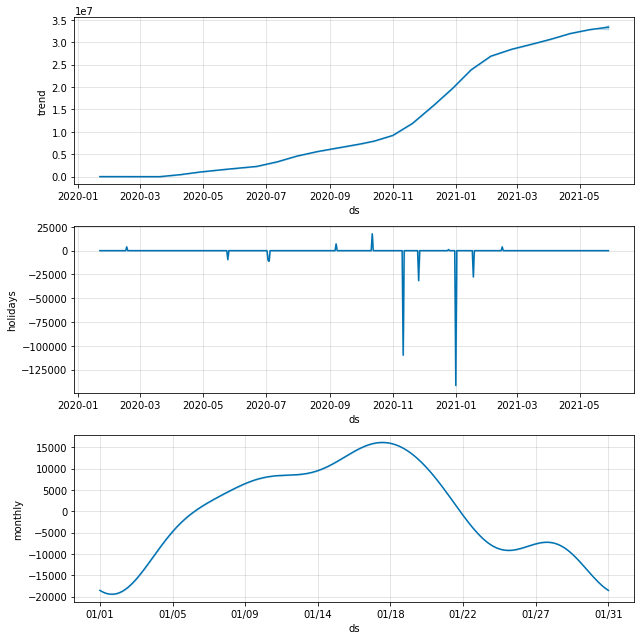

In [ ]:
model_us2.plot(predictions_us2)
model_us2.plot_components(predictions_us2);

In [ ]:
check_metrics(test_us, predictions_us2,split_range_us)

R-Squared Score:0.5671780111529436


In [ ]:
mean_squared_error(y_true=test_us['y'],
                   y_pred=predictions_us2['yhat'].iloc[split_range_us:])

4048725629.3609176

In [ ]:
mean_absolute_error(y_true=test_us['y'],
                   y_pred=predictions_us2['yhat'].iloc[split_range_us:])

59516.867275498276

# Hyperparameter Tuning US Daily Cases

In [ ]:
# param_grid = {
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'holidays_prior_scale':[0.01,0.1,1.0,10.0],
#     'seasonality_mode': ['additive', 'multiplicative']
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

In [ ]:
# # # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(train_us_daily)  # Fit model with given params
#     df_cv = cross_validation(m, period ='7 days', horizon='14 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

In [ ]:
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

# best_params = all_params[np.argmin(rmses)]
# print(best_params)

# US Daily Cases Tuned 38.04%

In [ ]:
model_us_daily = Prophet(weekly_seasonality = False, yearly_seasonality = False, daily_seasonality = False, 
                      seasonality_mode = 'additive', changepoint_prior_scale = 0.3, changepoint_range = 0.99, 
                      holidays_prior_scale = 0.01,
                      seasonality_prior_scale = 0.1)
model_us_daily.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5, prior_scale = 10)
model_us_daily.add_seasonality(name = 'weekly', period = 7, fourier_order = 3, prior_scale = 10)
model_us_daily.add_country_holidays(country_name = 'US')

In [ ]:
model_us_daily.fit(train_us_daily)
future_dates_us_daily = model_us_daily.make_future_dataframe(periods = 14)
predictions_us_daily = model_us_daily.predict(future_dates_us_daily)

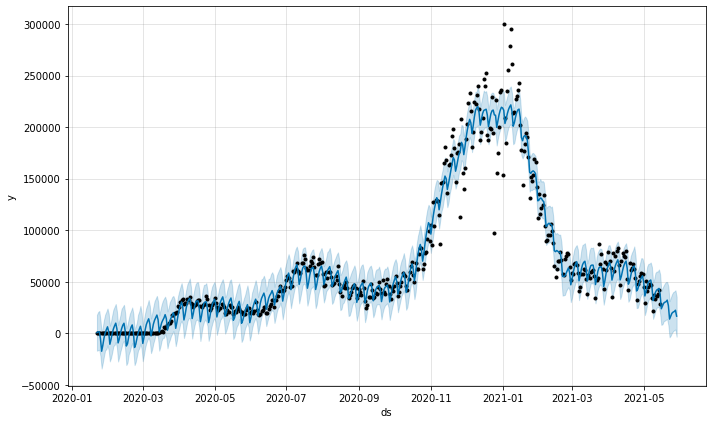

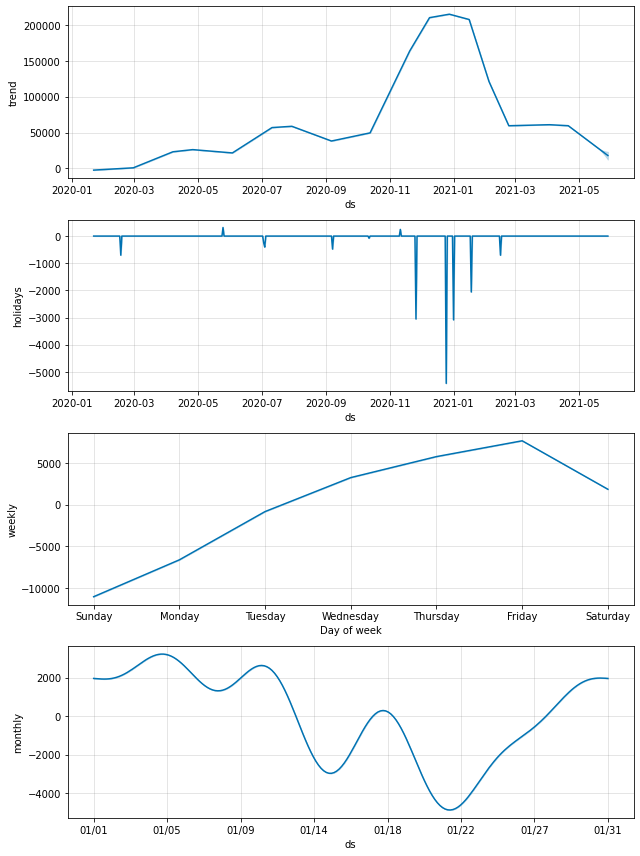

In [ ]:
model_us_daily.plot(predictions_us_daily)
model_us_daily.plot_components(predictions_us_daily);

In [ ]:
check_metrics(test_us_daily, predictions_us_daily,split_range_us)

R-Squared Score:0.38043334315590593


In [ ]:
mean_squared_error(y_true=test_us_daily['y'],
                   y_pred=predictions_us_daily['yhat'].iloc[split_range_us:])

21051905.975183632

In [ ]:
mean_absolute_error(y_true=test_us_daily['y'],
                   y_pred=predictions_us_daily['yhat'].iloc[split_range_us:])

3656.711120605903

In [ ]:
forecast_us_tuned_daily = predictions_us_daily[['ds','yhat_lower','yhat_upper','yhat']].tail(14).reset_index().set_index('ds').drop('index', axis = 1)
forecast_us_tuned_daily

,yhat_lower,yhat_upper,yhat
ds,,,
2021-05-16,8134.334415,40783.821579,23771.792944
2021-05-17,8710.938933,43843.269898,26364.212775
2021-05-18,11646.081825,46255.470725,29153.928745
2021-05-19,12277.768285,48403.907757,30089.672390
2021-05-20,13119.484131,49752.978235,30609.550967
2021-05-21,13753.775997,49772.829524,32123.952727
2021-05-22,7661.745849,45258.233750,26768.261673
2021-05-23,-3989.951234,31174.386510,13759.102064
2021-05-24,-2295.033221,34218.564967,16536.388961


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = test_us_daily['ds'], y = test_us_daily['y'], name = 'Actual',))
fig.add_trace(go.Scatter(x = forecast_us_tuned_daily.reset_index()['ds'] , y = forecast_us_tuned_daily['yhat_lower'],
                         line = dict(color = 'firebrick', width = 1, dash = 'dash'),name = 'Lower Uncertainty Interval',))
fig.add_trace(go.Scatter(x = forecast_us_tuned_daily.reset_index()['ds'] , y = forecast_us_tuned_daily['yhat_upper'],
                         line = dict(color = 'firebrick', width = 1, dash = 'dash'),name = 'Upper Uncertainty Interval',))
fig.add_trace(go.Scatter( x = forecast_us_tuned_daily.reset_index()['ds'], y = forecast_us_tuned_daily['yhat'], 
                             line = dict(color = 'firebrick'),name = 'Predicted',))
fig.update_layout(title = 'Actual vs Predicted Daily Cases in US', xaxis_title = 'Date', yaxis_title = 'Number of COVID-19 Cases')
fig.show()

In [ ]:
with open('model_us_daily.json', 'w') as fout:
    json.dump(model_to_json(model_us_daily), fout)  # Save model

# with open('model_us_daily.json', 'r') as fin:
#     m = model_from_json(json.load(fin))  # Load model

# Cross Validation - Cumulative US model & India Daily model

In [ ]:
us_cv = cross_validation(model_us, initial = '200 days', period = '7 days', horizon = '14 days')

INFO:fbprophet:Making 38 forecasts with cutoffs between 2020-08-15 00:00:00 and 2021-05-01 00:00:00


  0%|          | 0/38 [00:00<?, ?it/s]

In [ ]:
us_p = performance_metrics(us_cv)
us_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days,3.048770e+09,55215.671527,41267.189173,0.002614,0.002145,0.357001
1,3 days,5.383908e+09,73375.121694,54161.018877,0.003419,0.002619,0.247766
2,4 days,7.632089e+09,87361.826772,63665.238885,0.003911,0.002809,0.285998
3,5 days,1.098092e+10,104789.888037,77021.369435,0.004609,0.003615,0.240318
4,6 days,1.579756e+10,125688.354787,90095.803700,0.005161,0.003525,0.248262
5,7 days,2.251727e+10,150057.544469,108551.646312,0.006082,0.004179,0.225422
6,8 days,3.245082e+10,180141.118419,130801.690584,0.007333,0.004961,0.210526
7,9 days,4.425632e+10,210371.872553,151397.766354,0.008486,0.006200,0.210526
8,10 days,5.731636e+10,239408.355327,171494.399858,0.009644,0.007072,0.248262
9,11 days,7.066049e+10,265820.410636,191240.406778,0.010733,0.009016,0.263158


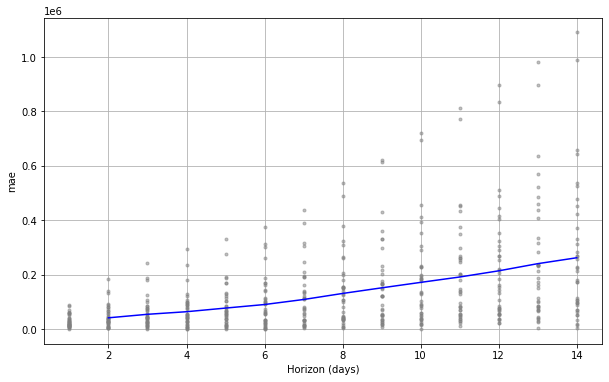

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(us_cv, metric='mae')

In [ ]:
india_daily_cv = cross_validation(model_india_daily, initial = '200 days', period = '7 days', horizon = '14 days')
india_daily_p = performance_metrics(india_daily_cv)
india_daily_p

INFO:fbprophet:Making 37 forecasts with cutoffs between 2020-08-22 00:00:00 and 2021-05-01 00:00:00


  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warnin

,horizon,mse,rmse,mae,mdape,coverage
0,2 days,4.530582e+08,21285.164460,11635.109127,0.159542,0.678325
1,3 days,4.772545e+08,21846.156370,12042.977136,0.154505,0.707472
2,4 days,3.296795e+08,18157.078919,10566.830493,0.139118,0.749338
3,5 days,3.874695e+08,19684.244382,12263.863985,0.161270,0.697933
4,6 days,5.648733e+08,23767.062771,13978.546599,0.203135,0.636460
5,7 days,7.712465e+08,27771.325551,15853.259396,0.207420,0.621622
6,8 days,1.250859e+09,35367.480138,18934.451781,0.181584,0.621622
7,9 days,1.863211e+09,43164.930132,23086.544732,0.351530,0.582406
8,10 days,2.133055e+09,46185.007994,24300.429301,0.268172,0.587175
9,11 days,2.132216e+09,46175.921246,23615.809038,0.254096,0.594595


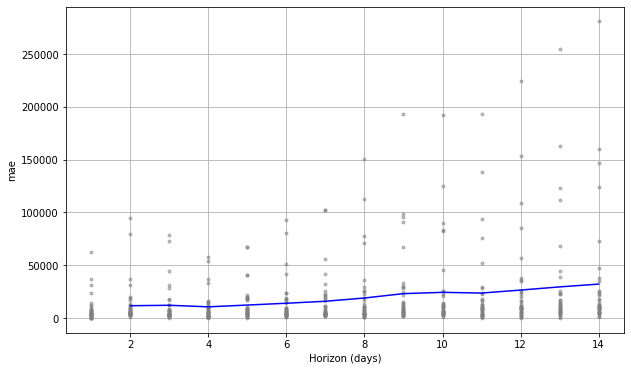

In [ ]:
fig = plot_cross_validation_metric(india_daily_cv, metric='mae')

# 2 Weeks Ahead Forecast (OOS)

2 weeks ahead forecast using whoe dataset as training dataset. Using India daily model settings and US cumulative model settings (best performing models)

**India**

In [ ]:
#model_daily_india_settings
model_india_daily_OOS = Prophet(weekly_seasonality = True, yearly_seasonality = False, daily_seasonality = False, 
                      seasonality_mode = 'additive', changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1, 
                       holidays_prior_scale = 0.01, changepoint_range = 0.99)
model_india_daily_OOS.add_country_holidays(country_name = 'IN')

In [ ]:
model_india_daily_OOS.fit(india_daily_new)
future_dates_india_daily_OOS = model_india_daily_OOS.make_future_dataframe(periods = 14)
predictions_india_daily_OOS = model_india_daily_OOS.predict(future_dates_india_daily_OOS)

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



In [ ]:
with open('model_india_daily_OOS.json', 'w') as fout:
    json.dump(model_to_json(model_india_daily_OOS), fout)  # Save model

# with open('model_india_daily_OOS.json', 'r') as fin:
#     m = model_from_json(json.load(fin))  # Load model

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



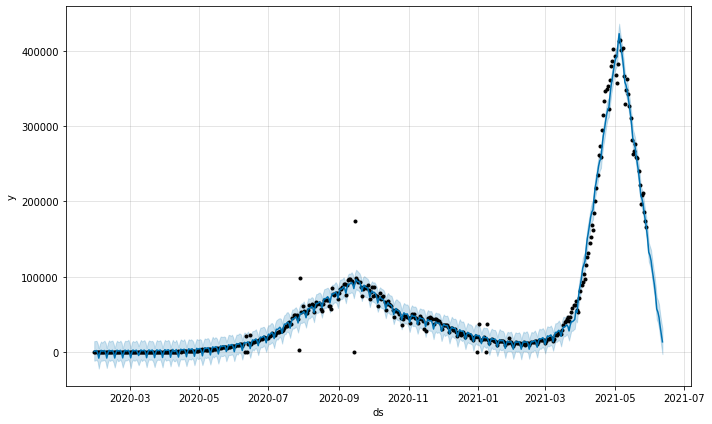

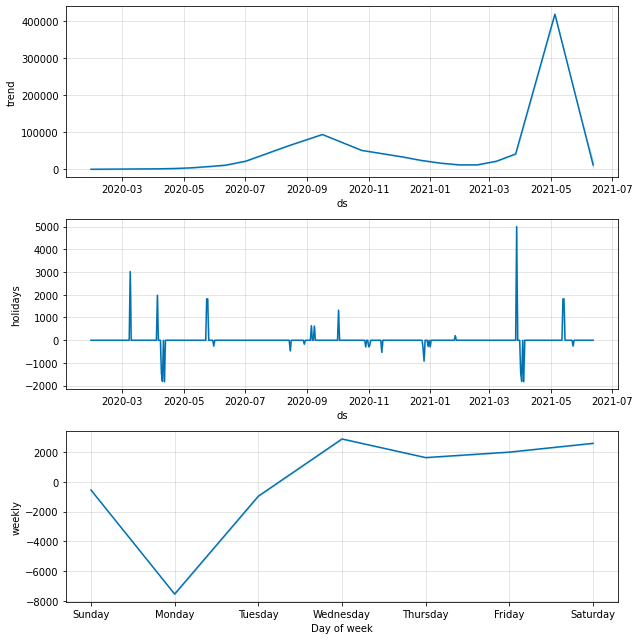

In [ ]:
model_india_daily_OOS.plot(predictions_india_daily_OOS);
model_india_daily_OOS.plot_components(predictions_india_daily_OOS);

Cross Validation

In [ ]:
india_daily_oos_cv = cross_validation(model_india_daily_OOS, initial = '200 days', period = '7 days', horizon = '14 days')
india_daily_oos_p = performance_metrics(india_daily_oos_cv)

INFO:fbprophet:Making 39 forecasts with cutoffs between 2020-08-22 00:00:00 and 2021-05-15 00:00:00


  0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.7/dist-packages/fbprophet/hdays.py:259: Warnin

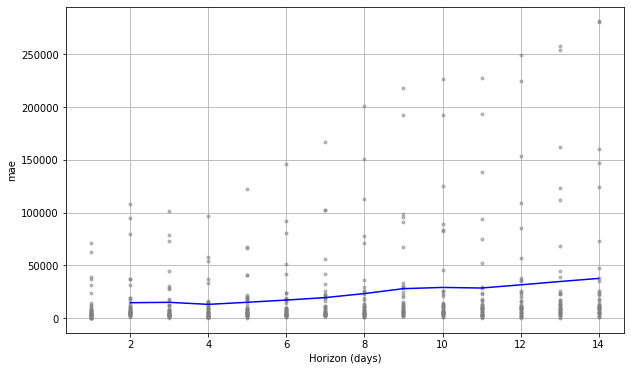

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(india_daily_oos_cv, metric='mae')

In [ ]:
forecast_india_daily_oos = predictions_india_daily_OOS[['ds','yhat_lower','yhat_upper','yhat']].tail(14).reset_index().set_index('ds').drop('index', axis = 1)

In [ ]:
forecast_india_daily_oos

,yhat_lower,yhat_upper,yhat
ds,,,
2021-05-30,137346.864737,162664.479676,150407.312937
2021-05-31,120351.507774,145411.070572,132684.016556
2021-06-01,115245.859753,140443.694090,128482.366295
2021-06-02,109716.427624,135878.865475,121559.319856
2021-06-03,96512.034721,123351.927662,109556.958832
2021-06-04,85013.244651,111973.624138,99169.652987
2021-06-05,75798.355536,102691.749754,89002.619291
2021-06-06,60874.508141,89118.471310,75123.717951
2021-06-07,43383.798446,72644.464391,57400.421571


In [ ]:
!pip install plotly>=4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [ ]:
from google.colab import files

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = india_daily_new['ds'], y = india_daily_new['y'], name = 'Actual',))

fig.add_trace(go.Scatter(x = forecast_india_daily_oos.reset_index()['ds'] , y = forecast_india_daily_oos['yhat_lower'],
                         line = dict(color = 'firebrick', width = 1, dash = 'dash'),name = 'Lower Uncertainty Interval',))

fig.add_trace(go.Scatter(x = forecast_india_daily_oos.reset_index()['ds'] , y = forecast_india_daily_oos['yhat_upper'],
                         line = dict(color = 'firebrick', width = 1, dash = 'dash'),name = 'Upper Uncertainty Interval',))

fig.add_trace(go.Scatter( x = forecast_india_daily_oos.reset_index()['ds'], y = forecast_india_daily_oos['yhat'], 
                             line = dict(color = 'firebrick'),name = 'Predicted',))

fig.update_layout(title = '14 Days Ahead Predicted Daily Cases in India', xaxis_title = 'Date', yaxis_title = 'Number of COVID-19 Cases')
fig.show()
fig.write_image("india_14_aheads.png")
files.download("india_14_aheads.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**US**

In [ ]:
#model_us settings
model_us_oos = Prophet(weekly_seasonality = False, yearly_seasonality = False, daily_seasonality = False, 
                      seasonality_mode = 'additive', changepoint_prior_scale = 0.3, changepoint_range = 0.99)
model_us_oos.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model_us_oos.add_country_holidays(country_name = 'US')

In [ ]:
model_us_oos.fit(us_confirmed)
future_dates_us_oos = model_us_oos.make_future_dataframe(periods = 14)
predictions_us_oos = model_us_oos.predict(future_dates_us_oos)

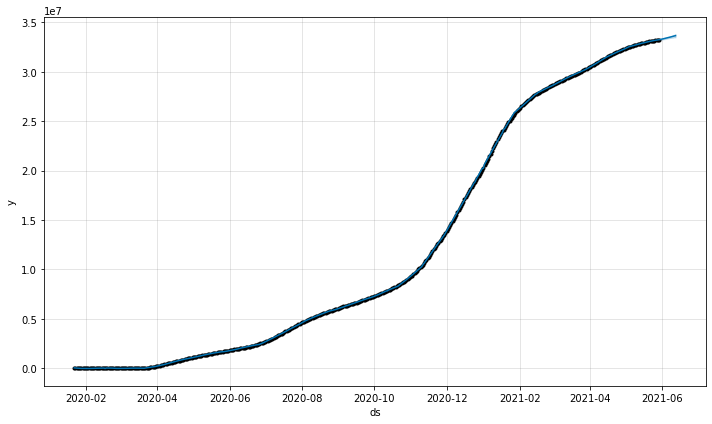

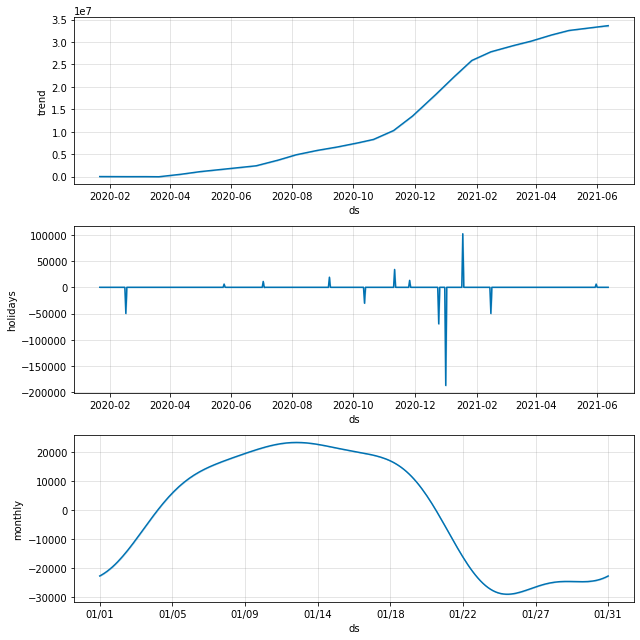

In [ ]:
model_us_oos.plot(predictions_us_oos);
model_us_oos.plot_components(predictions_us_oos);

In [ ]:
with open('model_us_oos.json', 'w') as fout:
    json.dump(model_to_json(model_us_oos), fout)  # Save model

# with open('model_us_oos.json', 'r') as fin:
#     m = model_from_json(json.load(fin))  # Load model

Cross Validation

In [ ]:
us_oos_cv = cross_validation(model_us_oos, initial = '200 days', period = '7 days', horizon = '14 days')
us_oos_p = performance_metrics(us_oos_cv)

INFO:fbprophet:Making 40 forecasts with cutoffs between 2020-08-15 00:00:00 and 2021-05-15 00:00:00


  0%|          | 0/40 [00:00<?, ?it/s]

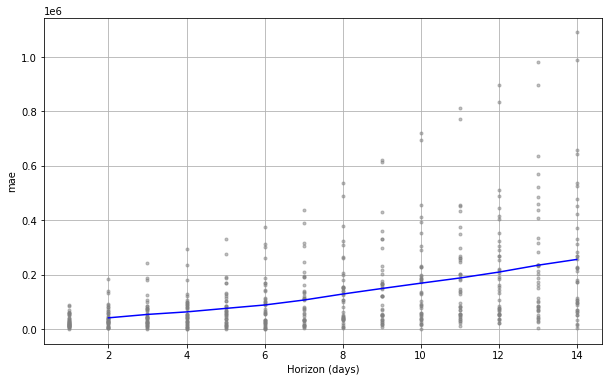

In [ ]:
fig = plot_cross_validation_metric(us_oos_cv, metric='mae')

In [ ]:
forecast_us_oos = predictions_us_oos[['ds','yhat_lower','yhat_upper','yhat']].tail(14).reset_index().set_index('ds').drop('index', axis = 1)
forecast_us_oos

,yhat_lower,yhat_upper,yhat
ds,,,
2021-05-30,3.322147e+07,3.332792e+07,3.327380e+07
2021-05-31,3.325050e+07,3.336387e+07,3.330689e+07
2021-06-01,3.327251e+07,3.338568e+07,3.332952e+07
2021-06-02,3.329889e+07,3.341756e+07,3.335810e+07
2021-06-03,3.331710e+07,3.344502e+07,3.338555e+07
2021-06-04,3.334751e+07,3.347733e+07,3.341236e+07
2021-06-05,3.337174e+07,3.350404e+07,3.344005e+07
2021-06-06,3.339221e+07,3.354258e+07,3.347005e+07
2021-06-07,3.342101e+07,3.357646e+07,3.350271e+07


Use predicted cumulative numbers to back calculate daily number of cases.

In [ ]:
forecast_us_oos['yhat_lower_diff'] = forecast_us_oos['yhat_lower']/forecast_us_oos['yhat']
forecast_us_oos['yhat_upper_diff'] = forecast_us_oos['yhat_upper'] /forecast_us_oos['yhat']

In [ ]:
last_ob = us_confirmed[493:]
last_ob = last_ob.rename({'y': 'yhat'}, axis=1)
forecast_us_oos = forecast_us_oos.reset_index()

In [ ]:
merged = forecast_us_oos.append(last_ob)
merged = merged.set_index('ds').sort_index()

In [ ]:
merged['Predicted Daily New Cases'] = merged.sort_index()['yhat'].transform(lambda x:x.diff())
merged['Predicted Daily New Cases lower'] = merged['Predicted Daily New Cases'] * merged['yhat_lower_diff']
merged['Predicted Daily New Cases upper'] = merged['Predicted Daily New Cases'] * merged['yhat_upper_diff']

In [ ]:
merged = merged[1:]

In [ ]:
merged

,yhat_lower,yhat_upper,yhat,yhat_lower_diff,yhat_upper_diff,Predicted Daily New Cases,Predicted Daily New Cases lower,Predicted Daily New Cases upper
ds,,,,,,,,
2021-05-30,3.322147e+07,3.332792e+07,3.327380e+07,0.998427,1.001627,21857.626485,21823.250735,21893.179511
2021-05-31,3.325050e+07,3.336387e+07,3.330689e+07,0.998307,1.001711,33095.518165,33039.486024,33152.136816
2021-06-01,3.327251e+07,3.338568e+07,3.332952e+07,0.998290,1.001685,22630.387039,22591.678109,22668.517330
2021-06-02,3.329889e+07,3.341756e+07,3.335810e+07,0.998225,1.001782,28579.577750,28528.845136,28630.517011
2021-06-03,3.331710e+07,3.344502e+07,3.338555e+07,0.997950,1.001781,27444.371934,27388.105461,27493.261820
2021-06-04,3.334751e+07,3.347733e+07,3.341236e+07,0.998059,1.001944,26815.175209,26763.130461,26867.313588
2021-06-05,3.337174e+07,3.350404e+07,3.344005e+07,0.997957,1.001914,27693.205110,27636.628708,27746.196704
2021-06-06,3.339221e+07,3.354258e+07,3.347005e+07,0.997675,1.002167,29990.829204,29921.088157,30055.823297
2021-06-07,3.342101e+07,3.357646e+07,3.350271e+07,0.997561,1.002201,32668.787069,32589.117525,32740.693856


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter( x = us_daily_new['ds'], y = us_daily_new['y'], name = 'Actual',))

fig.add_trace(go.Scatter(x = merged.reset_index()['ds'] , y = merged['Predicted Daily New Cases lower'],
                         line = dict(color = 'firebrick', width = 1, dash = 'dash'),name = 'Lower Uncertainty Interval',))

fig.add_trace(go.Scatter(x = merged.reset_index()['ds'] , y = merged['Predicted Daily New Cases upper'],
                         line = dict(color = 'firebrick', width = 1, dash = 'dash'),name = 'Upper Uncertainty Interval',))

fig.add_trace(go.Scatter( x = merged.reset_index()['ds'], y = merged['Predicted Daily New Cases'], 
                             line = dict(color = 'firebrick'),name = 'Predicted',))

fig.update_layout(title = '14 Days Ahead Predicted Daily Cases in US', xaxis_title = 'Date', yaxis_title = 'Number of COVID-19 Cases')
fig.show()
fig.write_image("us_14_aheads.png")
files.download("us_14_aheads.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from scipy.special import boxcox1p, inv_boxcox1p

In [ ]:
train_us_daily_bcx = copy.deepcopy(train_us_daily)

In [ ]:
train_us_daily_bcx['y'] = boxcox1p(train_us_daily_bcx['y'], 0.25)

In [ ]:
test_us_daily_bcx = copy.deepcopy(test_us_daily)
test_us_daily_bcx['y'] = boxcox1p(test_us_daily_bcx['y'], 0.25)

In [ ]:
model_us_daily_bcx = Prophet(weekly_seasonality = True, yearly_seasonality = False, daily_seasonality = True, 
                      seasonality_mode = 'additive', changepoint_prior_scale = 0.5, changepoint_range = 0.99,
                       holidays_prior_scale = 0.01, seasonality_prior_scale = 0.1)
model_us_daily_bcx.add_country_holidays(country_name = 'US')

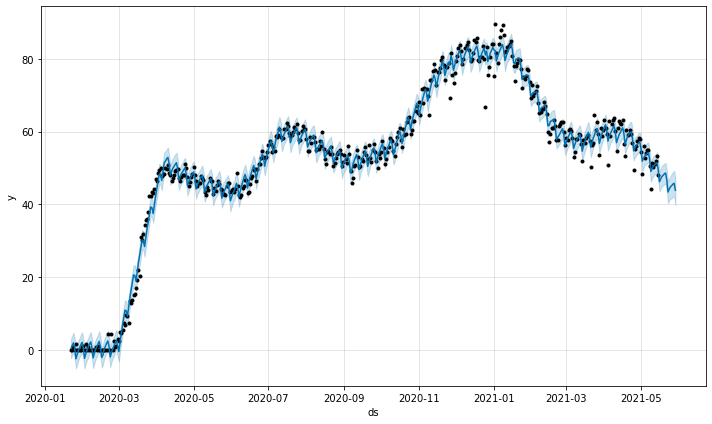

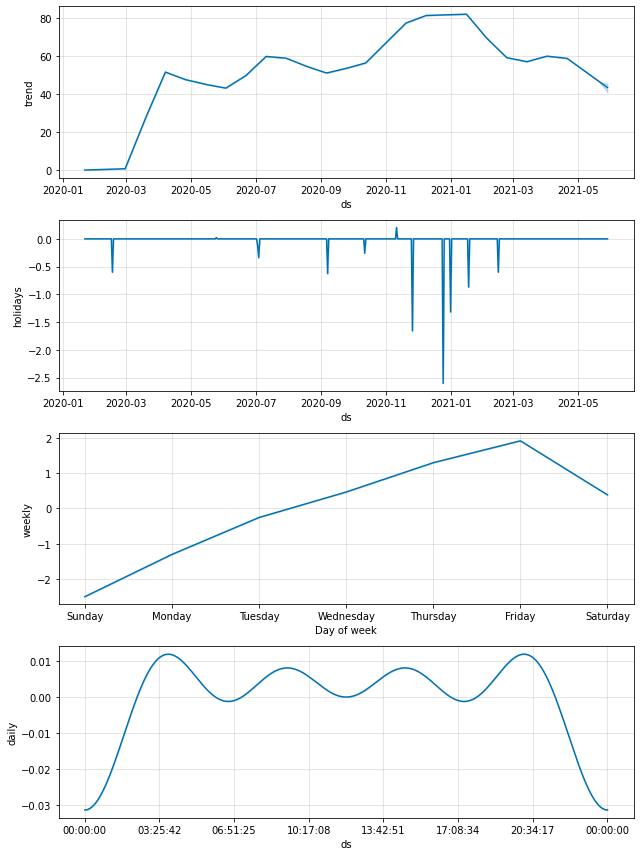

In [ ]:
model_us_daily_bcx.fit(train_us_daily_bcx)
future_dates_us_bcx = model_us_daily_bcx.make_future_dataframe(periods = 14)
predictions_us_bcx = model_us_daily_bcx.predict(future_dates_us_bcx)

model_us_daily_bcx.plot(predictions_us_bcx)
model_us_daily_bcx.plot_components(predictions_us_bcx);

In [ ]:
check_metrics(test_us_daily_bcx, predictions_us_bcx,split_range_us)

R-Squared Score:0.3631118975555895


In [ ]:
mean_squared_error(y_true=test_us_daily_bcx['y'],
                   y_pred=predictions_us_bcx['yhat'].iloc[split_range_us:])

7.5472340173717365

In [ ]:
mean_absolute_error(y_true=test_us_daily_bcx['y'],
                   y_pred=predictions_us_bcx['yhat'].iloc[split_range_us:])

1.9771827644679223